# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки:**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя


**Целевой признак:**
- `Price` — цена (евро)

**Импорт необходимых библиотек:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
import time

## Подготовка данных

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Очевидно, что среди признаков имеются неинформативные, такие как:** 

- `DateCrawled` — дата скачивания анкеты из базы
- `DateCreated` — дата создания анкеты
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя
- `NumberOfPictures` — количество фотографий автомобиля 

**Удалим их.**

In [6]:
data = data.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis=1)

Подумаем еще, влияет ли как-то месяц __постановки автомобиля на учёт__ `RegistrationMonth`  на его цену - важно ли будущему автовладельцу, что его автомобиль поставлен на учёт, скажем, в сентябре, а не в июне?

In [7]:
# Вычисление корреляции
correlation = data['RegistrationMonth'].corr(data['Price'])
print("Корреляция между признаком RegistrationMonth и признаком Price:", correlation)

Корреляция между признаком RegistrationMonth и признаком Price: 0.11058102775308232


Корреляция между признаками RegistrationMonth (месяц регистрации автомобиля) и Price (цена автомобиля) равна примерно 0.11.

Значение корреляции близкое к нулю указывает на то, что между этими двумя признаками есть очень слабая линейная зависимость. Это означает, что изменения в месяце регистрации автомобиля слабо связаны с изменениями в его цене.

В этом случае, можно предположить, что месяц регистрации автомобиля не является существенным фактором при определении его цены. Удалим этот признак тоже.

In [8]:
data = data.drop(['RegistrationMonth'], axis=1)

**Изучим пропущенные значения:**

In [9]:
# Вывод количества пропущенных значений в каждом столбце
missing_values = data.isnull().sum()

# Вывод процента пропущенных значений в каждом столбце
percentage_missing = ((data.isnull().sum() / len(data)) * 100).round(2)

# Создание DataFrame для удобства отображения
missing_info = pd.DataFrame({
    'Количество пропущенных значений': missing_values,
    'Процент пропущенных значений': percentage_missing
})

# Вывод информации о пропущенных значениях
missing_info

,Количество пропущенных значений,Процент пропущенных значений
Price,0,0.00
VehicleType,37490,10.58
RegistrationYear,0,0.00
Gearbox,19833,5.60
Power,0,0.00
Model,19705,5.56
Kilometer,0,0.00
FuelType,32895,9.28
Brand,0,0.00
Repaired,71154,20.08


**Пропуски обнаружились в столбцах:**
- `VehicleType` — тип автомобильного кузова (10.58% пропущенных значений)
- `Gearbox` — тип коробки передач (5.6% пропущенных значений)
- `Model` — модель автомобиля (5.56% пропущенных значений)
- `FuelType` — тип топлива (9.28% пропущенных значений)
- `Repaired` — была машина в ремонте или нет (20.08% пропущенных значений)

Каждая запись представляет собой ценный кусочек информации. Удалять данные в нашем случае точно не лучший вариант, поскольку они могут содержать важные паттерны или отражать специфические характеристики наших данных.

В случае признаков, таких как тип автомобильного кузова, тип коробки передач, модель автомобиля, тип топлива и информация о ремонте, удаление данных представляется слишком рискованным шагом. Эти признаки могут содержать ключевую информацию, которая влияет на наше понимание данных и на результаты анализа.

Однако, заполнение пропущенных значений в категориальных признаках также представляет свои трудности. Без конкретной информации о природе этих пропущенных значений мы вынуждены принять решение о том, как их заполнить. В этом случае мы решаем использовать заглушку "unknown" для каждого из этих признаков. Даже для столбца, указывающего на то, проходила ли машина ремонт или нет, мы прибегаем к использованию "unknown". Это объясняется тем, что сложно сказать, почему данные значения отсутствуют. Возможно, пользователь забыл заполнить это поле, или же он намеренно скрывает информацию о том, что его машина побывала в ремонте.

Таким образом, заполнение пропущенных значений заглушкой "unknown" позволяет нам сохранить ценную информацию, содержащуюся в наших данных, и продолжить анализ, минимизируя влияние пропусков на результаты исследования.

In [10]:
# Список признаков, в которых есть пропуски
unknown_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']

# Заполнение пропущенных значений в признаках заглушкой "unknown"
for feature in unknown_features:
    data[feature].fillna('unknown', inplace=True)

**Проверим на наличие явных дубликатов:**

In [11]:
num_duplicated = data.duplicated().sum()

data_sorted = data.sort_values(by=data.columns.tolist())

duplicates = data_sorted[data_sorted.duplicated(keep=False)]

print("Явные дубликаты:")
duplicates.tail(30)

Явные дубликаты:


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
94360,20000,sedan,2011,auto,265,c_klasse,50000,gasoline,mercedes_benz,no
95559,20000,sedan,2011,auto,265,c_klasse,50000,gasoline,mercedes_benz,no
100514,20000,sedan,2011,auto,265,c_klasse,50000,gasoline,mercedes_benz,no
107730,20000,sedan,2011,auto,265,c_klasse,50000,gasoline,mercedes_benz,no
115867,20000,sedan,2011,auto,265,c_klasse,50000,gasoline,mercedes_benz,no
126073,20000,sedan,2011,auto,265,c_klasse,50000,gasoline,mercedes_benz,no
174393,20000,sedan,2011,auto,265,c_klasse,50000,gasoline,mercedes_benz,no
201971,20000,sedan,2011,auto,265,c_klasse,50000,gasoline,mercedes_benz,no
203409,20000,sedan,2011,auto,265,c_klasse,50000,gasoline,mercedes_benz,no
212039,20000,sedan,2011,auto,265,c_klasse,50000,gasoline,mercedes_benz,no


In [12]:
print('Количество явных дубликатов:', num_duplicated)

Количество явных дубликатов: 45040


In [13]:
# Удаляем явные дубликаты
data.drop_duplicates(inplace=True)

**Проведем более детальное исследование данных:**

Основная информация о признаке: Price
count    309329.000000
mean       4486.937196
std        4564.852796
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64


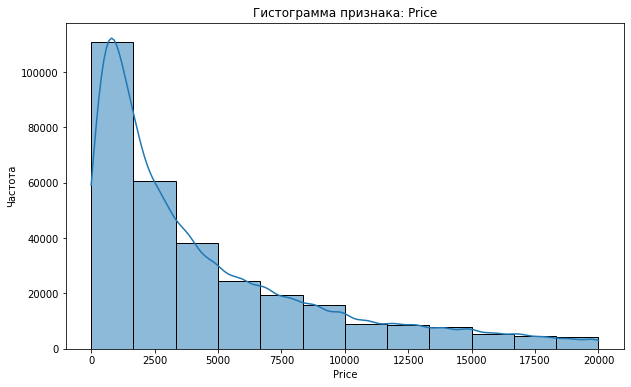

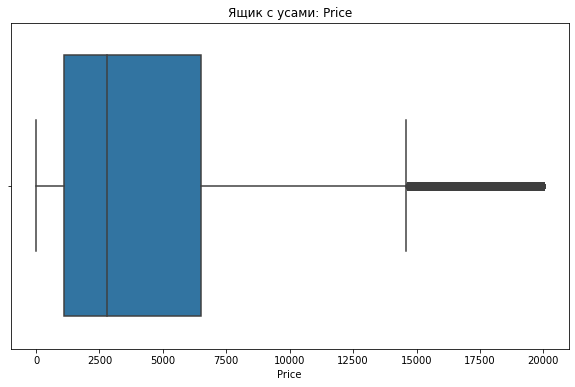

Основная информация о признаке: RegistrationYear
count    309329.000000
mean       2004.360105
std          92.541399
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64


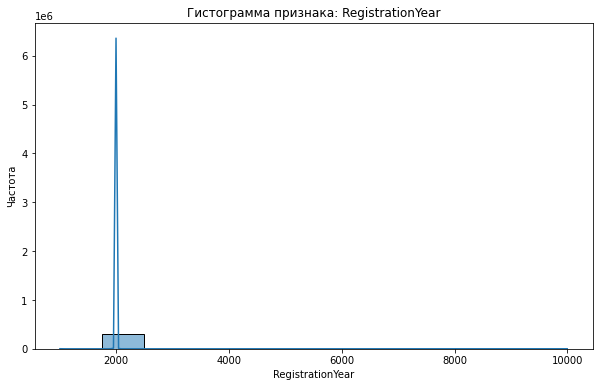

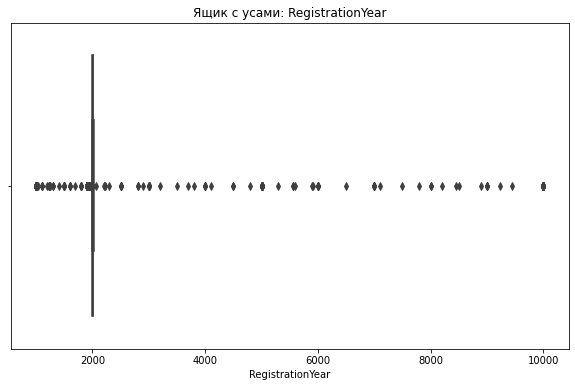

Основная информация о признаке: Power
count    309329.000000
mean        110.976908
std         200.969473
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64


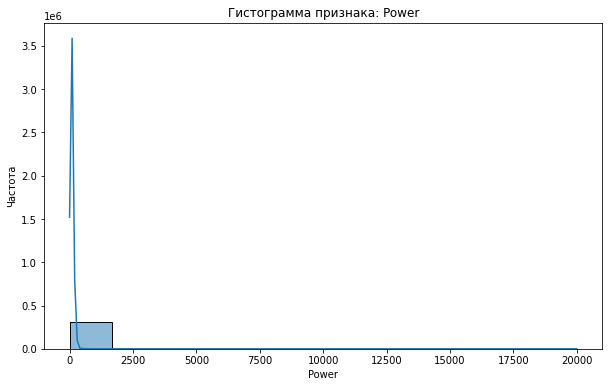

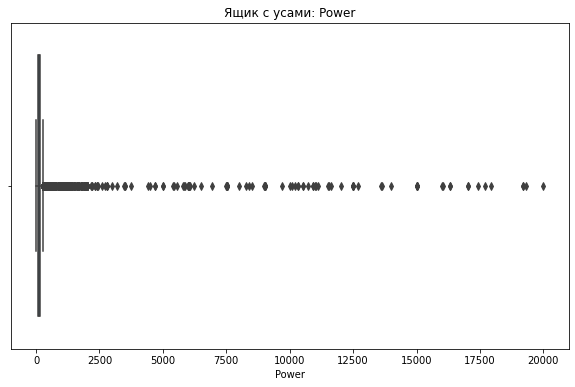

Основная информация о признаке: Kilometer
count    309329.000000
mean     127217.735809
std       38532.941010
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64


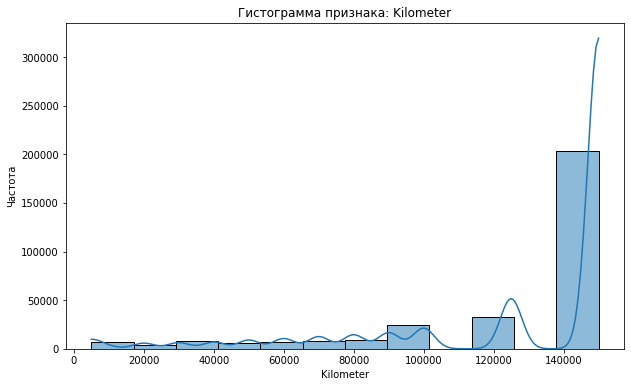

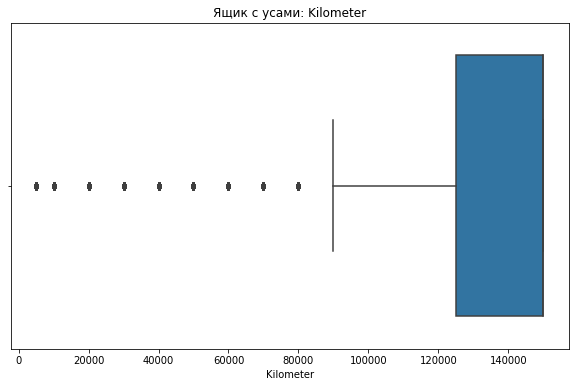

In [14]:
numerical_features = data.select_dtypes(include=['int', 'float']).columns

for feature in numerical_features:
    # Вывод основной информации о признаке
    print(f"Основная информация о признаке: {feature}")
    print(data[feature].describe())
    
    # Построение гистограммы
    plt.figure(figsize=(10, 6))
    sns.histplot(data[feature], kde=True, bins=12) 
    plt.title(f"Гистограмма признака: {feature}")
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.show()
    
    # Построение ящика с усами (boxplot)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[feature])
    plt.title(f"Ящик с усами: {feature}")
    plt.xlabel(feature)
    plt.show()

**Разберемся с аномальными значениями в столбцах:**

`RegistrationYear — год регистрации автомобиля`: удалим строки, где год регистрации ниже 1910 и превышает дату выгрузки.

In [15]:
data = data.drop(data[(data['RegistrationYear'] > 2016) | (data['RegistrationYear'] < 1910)].index, axis=0)

`Power — мощность (л. с.)`: машин с мощностью более 2000 л. с. не существует, удалим аномальные значения, превышающие максимально возможный показатель, а также удалим нулевые значения мощности - некоторые значения этого признака в таблице напоминают, скорее, телегу с конём, чем автомобиль:)

In [16]:
data = data.drop(data[(data['Power'] > 2000) & (data['Power'] == 0)].index, axis=0)

**Разберемся с неявными дубликатами:**

In [17]:
data['FuelType'].unique()

array(['petrol', 'gasoline', 'unknown', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

`FuelType` - значения `petrol` и `gasoline` по сути означают одно и то же, можно привести к одной форме.

In [18]:
data['FuelType'] = data['FuelType'].replace('gasoline', 'petrol')

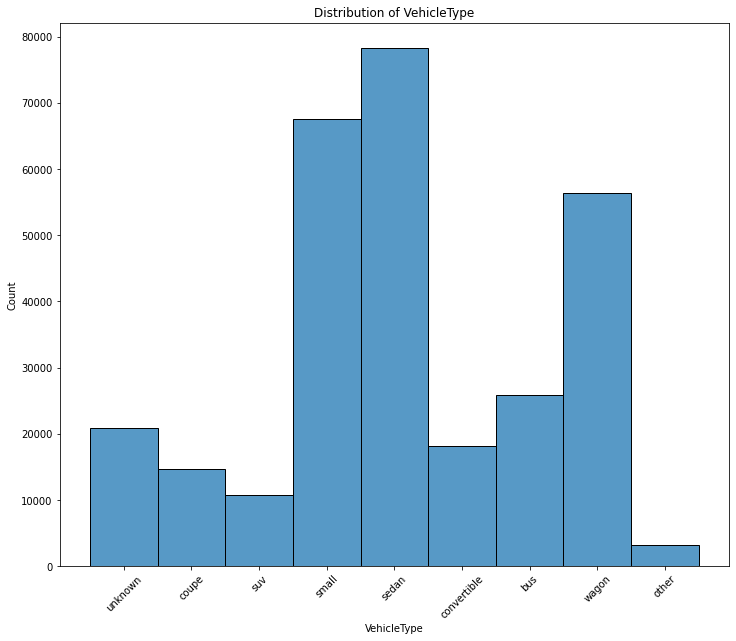

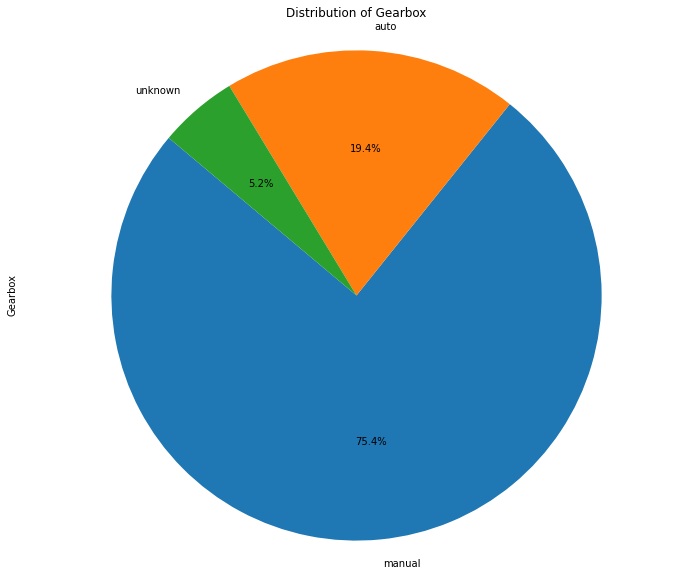

,Model,Count
0,other,22403
1,golf,22206
2,unknown,16381
3,3er,16193
4,polo,9932
...,...,...
246,kalina,5
247,serie_3,4
248,rangerover,3
249,serie_1,2


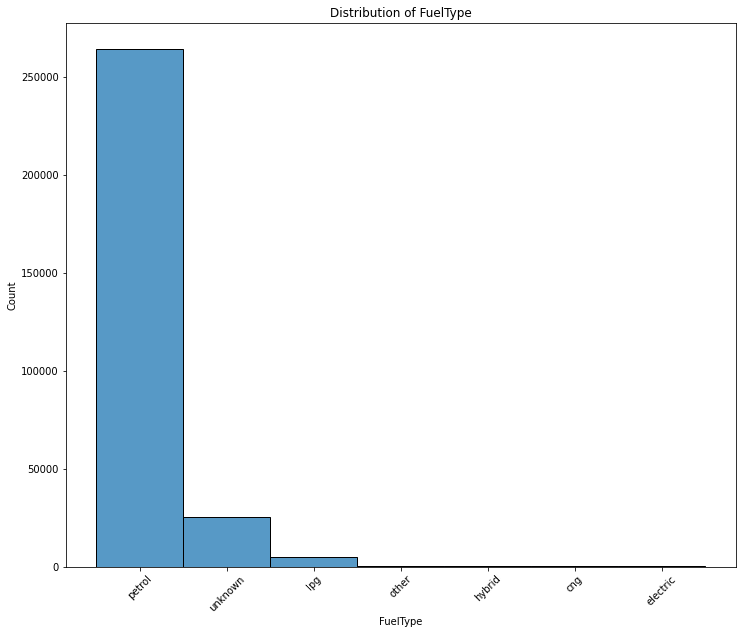

,Brand,Count
0,volkswagen,60413
1,opel,32154
2,bmw,30661
3,mercedes_benz,27712
4,audi,24539
5,ford,21447
6,renault,14854
7,peugeot,9454
8,fiat,8222
9,seat,5834


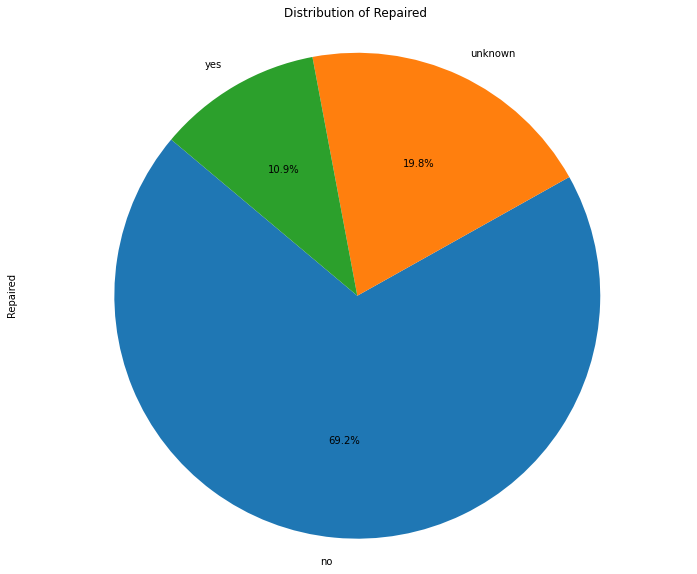

In [19]:
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()

for column in categorical_columns:
    unique_values = data[column].nunique()
    if column not in ['Model', 'Brand']:
        if unique_values <= 5:
            # Создаем круговую диаграмму для процентов каждой категории
            plt.figure(figsize=(12, 10))
            data[column].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140)
            plt.title(f'Distribution of {column}')
            plt.axis('equal')  # Устанавливаем соотношение сторон для круговой диаграммы, чтобы она была круглой
            plt.show()
        else:
            # Создаем гистограмму для распределения значений признака по оси Y
            plt.figure(figsize=(12, 10))
            sns.histplot(data=data, x=column)
            plt.title(f'Distribution of {column}')
            plt.xlabel(column)
            plt.ylabel('Count')
            plt.xticks(rotation=45)  # Поворачиваем подписи по оси X, чтобы они не перекрывались
            plt.show()
    else:
        # Построение сводной таблицы для столбцов 'model' и 'brand'
        pivot_table = data[[column]].value_counts().reset_index()
        pivot_table.columns = [column, 'Count']
        display(pivot_table)


**Подготовка выборок для обучения моделей:**

In [20]:
features = data.drop(['Price'], axis=1)
target = data['Price']

**Будем использовать функцию train_test_split(), чтобы разделить исходные данные (features и target) на обучающую выборку (features_train и target_train) и еще одну выборку, которую мы назовем тестовой (features_test и target_test).**

In [21]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.2, 
                                                                            random_state=12345
                                                                           ) 

In [22]:
print("Обучающая выборка:")
print(features_train.shape)
print(target_train.shape)

print("\nТестовая выборка:")
print(features_test.shape)
print(target_test.shape)

Обучающая выборка:
(236540, 9)
(236540,)

Тестовая выборка:
(59135, 9)
(59135,)


### Вывод: 

- Изучили данные;
- Обработали пропущенные значения и обосновали;
- Обработали аномалии в столбцах;
- Удалили неинформативные признаки;
- Подготовили выборки для обучения моделей.

## Обучение моделей

Модель случайного леса (`Random Forest`) хорошо подходит для задачи прогнозирования цен на автомобили по следующим причинам:

- Устойчивость к переобучению: Случайный лес состоит из множества решающих деревьев, каждое из которых обучается на случайной подвыборке данных. Это помогает снизить переобучение и повысить обобщающую способность модели.

- Обработка нелинейных зависимостей: Случайный лес способен обрабатывать сложные нелинейные взаимосвязи между признаками и целевой переменной.

- Стабильность: Случайный лес устойчив к выбросам и шуму в данных.

- Относительно небольшие настройки гиперпараметров: В общем случае, модель случайного леса не требует сложной настройки гиперпараметров для достижения хороших результатов, что упрощает процесс моделирования.

В целом, случайный лес является мощным алгоритмом машинного обучения, который обычно демонстрирует хорошую производительность на разнообразных наборах данных, включая задачи прогнозирования цен.

In [23]:
# Создание OrdinalEncoder с настройками для обработки неизвестных значений
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Преобразование категориальных признаков в числовые для всех выборок
features_train_encoded = features_train.copy()
features_test_encoded = features_test.copy()

for col in categorical_columns:
    features_train_encoded[col] = encoder.fit_transform(features_train[[col]])
    features_test_encoded[col] = encoder.transform(features_test[[col]])

**Добавим гиперпараметры:**

In [24]:
# Определение гиперпараметров для настройки
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Создание модели случайного леса
rf_model = RandomForestRegressor(random_state=12345)

# Определение метрики RMSE в качестве scorer
scorer = make_scorer(mean_squared_error, squared=False)

# Поиск оптимальных гиперпараметров с использованием RMSE в качестве метрики
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring=scorer)
start_time = time.time()
grid_search.fit(features_train_encoded, target_train)
end_time = time.time()

# Время поиска лучшей модели
search_time = end_time - start_time
print("Время поиска лучших параметров: {:.2f} секунд".format(search_time))

# Получение лучших параметров и лучшей модели
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Обучение лучшей модели и замер времени
start_time = time.time()
best_model.fit(features_train_encoded, target_train)
end_time = time.time()

# Время обучения лучшей модели
training_time_rf = end_time - start_time
print("Время обучения лучшей модели: {:.2f} секунд".format(training_time_rf))

# Измерение времени предсказания с помощью лучшей модели на train
start_time = time.time()
predictions_train = best_model.predict(features_train_encoded)
end_time = time.time()

# Время предсказания с помощью лучшей модели 
prediction_time_rf_train = end_time - start_time
print("Время предсказания на train: {:.2f} секунд".format(prediction_time_rf_train))

# Оценка модели на кросс-валидации
cv_score_rf = grid_search.best_score_
print("Оценка модели на кросс-валидации (best_score_): {:.4f}".format(cv_score_rf))

# Вывод лучших параметров
print("Лучшие параметры:", best_params)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  20.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  20.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  20.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  42.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  43.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  40.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  18.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  18.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  18.2s
[CV] END max_depth

**Модель `LightGBM`:**

**Добавим гиперпараметры:**

In [25]:
# Определение гиперпараметров для подбора
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 10],
    'num_leaves': [31, 50],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

# Создание модели
lgb_model = LGBMRegressor(random_state=12345)


# Определение метрики RMSE в качестве scorer
scorer = make_scorer(mean_squared_error, squared=False)

# Поиск лучших параметров
start_time = time.time()
random_search = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_grid, n_iter=10, cv=3, random_state=12345, verbose=2, 
                                   n_jobs=-1, scoring=scorer)
random_search.fit(features_train_encoded, target_train)
end_time = time.time()

# Время обучения
training_time = end_time - start_time
print("Время поиска лучшей модели: {:.2f} секунд".format(training_time))

# Лучшие параметры
best_params = random_search.best_params_
print("Лучшие гиперпараметры:", best_params)

# Получение лучшей модели
best_model = random_search.best_estimator_

# Обучение лучшей модели и замер времени
start_time = time.time()
best_model.fit(features_train_encoded, target_train)
end_time = time.time()

# Время обучения лучшей модели
training_time_lgb = end_time - start_time
print("Время обучения лучшей модели: {:.2f} секунд".format(training_time_lgb))

# Измерение времени предсказания с помощью лучшей модели на train
start_time = time.time()
predictions_train = best_model.predict(features_train_encoded)
end_time = time.time()

# Время предсказания с помощью лучшей модели 
prediction_time_lgb_train = end_time - start_time
print("Время предсказания на train: {:.2f} секунд".format(prediction_time_lgb_train))

# Оценка модели на кросс-валидации
cv_score_lgb = random_search.best_score_
print("Оценка модели на кросс-валидации (best_score_): {:.4f}".format(cv_score_lgb))

# Вывод лучших параметров
print("Лучшие параметры:", best_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=50, subsample=0.8; total time=10.2min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=50, subsample=0.8; total time=10.4min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=50, subsample=0.8; total time= 7.4min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.8; total time=  35.7s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.8; total time= 2.0min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.8; total time= 2.6min
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.8; total time= 2.4min
[CV] END colsample_bytree=0.

### Вывод:

Обучили разные модели, одна из которых — `LightGBM`, вторая - `RandomForest`. Для каждой модели подобрали лучшие гиперпараметры, проверили их качество.

## Анализ моделей

**Проанализируем время обучения, время предсказания и качество моделей, выберем лучшую для заказчика:**

Лучшие гиперпараметры для `RandomForest`: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Лучшие гиперпараметры для `LightGBM`: {'subsample': 0.8, 'num_leaves': 50, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

**Для сравнения моделей создадим DataFrame, в который войдут время обучения, время предсказания, качество лучших моделей:**

In [26]:
# Создание DataFrame
data_result = {
    'Модель': ['RandomForest', 'LightGBM'],
    'Время обучения (сек)': [training_time_rf, training_time_lgb],
    'Время предсказания с помощью кросс-валидации (сек)': [prediction_time_rf_train, prediction_time_lgb_train],
    'RMSE': [cv_score_rf, cv_score_lgb]
}

result = pd.DataFrame(data_result)


# Вывод таблицы
result

,Модель,Время обучения (сек),Время предсказания с помощью кросс-валидации (сек),RMSE
0,RandomForest,14.187944,0.922388,2032.737514
1,LightGBM,46.885429,1.531545,1897.087820


Исходя из критериев, которые были важны заказчику (качество предсказания, время обучения модели и время предсказания модели), можно принять решение о выборе лучшей модели. В данном случае, по результатам предоставленных данных, можно провести следующий анализ:

- Качество предсказания (RMSE):

  - RandomForest: 2032.74
  - LightGBM: 1897.09

LightGBM демонстрирует немного лучшее качество предсказания по сравнению с RandomForest.

- Время обучения модели:

  - RandomForest: 14.19 сек.
  - LightGBM: 46.89 сек.
  
RandomForest требует меньше времени на обучение по сравнению с LightGBM.

- Время предсказания модели с помощью кросс-валидации:

  - RandomForest: 0.92 сек.
  - LightGBM: 1.53 сек.
  
RandomForest также демонстрирует меньшее время предсказания по сравнению с LightGBM.

**Таким образом, учитывая все критерии, наилучшим выбором может быть RandomForest. Он предлагает хорошее качество предсказания с более низким временем обучения и предсказания по сравнению с LightGBM.**

**Проверим лучшую модель на тестовом наборе:**

In [29]:
# Создание модели случайного леса с лучшими гиперпараметрами
best_rf_model = RandomForestRegressor(random_state=12345, max_depth=10, min_samples_leaf=1, 
                                 min_samples_split=2, n_estimators=50)

# Обучение модели
start_time = time.time()
best_rf_model.fit(features_train_encoded, target_train)
end_time = time.time()

# Время обучения
best_rf_training_time = end_time - start_time
print("Время обучения: {:.2f} секунд".format(best_rf_training_time))

# Предсказание на тестовой выборке
start_time = time.time()
test_predictions = best_rf_model.predict(features_test_encoded)
end_time = time.time()

# Время предсказания на тестовой выборке
best_rf_prediction_time = end_time - start_time
print("Время предсказания на тестовой выборке: {:.2f} секунд".format(best_rf_prediction_time))

# Оценка качества модели на тренировочной выборке с помощью RMSE
best_rf_test_rmse = mean_squared_error(target_test, test_predictions, squared=False)
print("RMSE на тестовой выборке: {:.2f}".format(best_rf_test_rmse))

Время обучения: 15.10 секунд
Время предсказания на тестовой выборке: 0.24 секунд
RMSE на тестовой выборке: 2038.32


**Проверим лучшую модель на адекватность, сравнив качество её предсказаний с качеством модели, которая предсказывала бы константу:**

In [30]:
# Создание DummyRegressor, который предсказывает среднее значение целевой переменной
dummy_model = DummyRegressor(strategy='mean')

# Обучение DummyRegressor
dummy_model.fit(features_train_encoded, target_train)

# Предсказание среднего значения на тестовой выборке
dummy_predictions = dummy_model.predict(features_test_encoded)

# Оценка качества DummyRegressor на тестовой выборке с помощью RMSE
dummy_rmse = mean_squared_error(target_test, dummy_predictions, squared=False)
print("RMSE DummyRegressor на тестовой выборке: {:.2f}".format(dummy_rmse))

RMSE DummyRegressor на тестовой выборке: 4615.18


RMSE нашей модели значительно ниже, чем RMSE DummyRegressor, то это говорит о том, что наша модель действительно обучилась и предсказывает данные лучше, чем просто предсказание константного значения.

### Вывод:

Критерии, которые были важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

Обосновали по всем критериям выбор модели и лидером стала модель RandomForest, поэтому для заказчика рекомендуем использовать её.

## Итог работы

- Изучили данные. Обработали пропущенные значения и аномалии в столбцах. Удалили неинформативные признаки.
- Подготовили выборки для обучения моделей.
- Обучите разные модели, одна из которых — LightGBM, вторая - RandomForest. Для каждой модели подобрали лучшие гиперпараметры.
- Проанализировали время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выбрали лучшую модель.